# calibration - compare scale with geometry correction in Gonzalo's method
# Does the gometry map improves the resolution compared with using only the scale map?

## JAH 04/08/18

<i>
Compare calibration in Kr resolution using corrections from Gonzalo's method with Scale (obtained from the lifetime) and Geometry (with the gaussian refinement in x,y bins)
</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sat Aug  4 22:46:35 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number                 = 6206
input_dst_filenames        = [f"$IC_DATA/dsts/kdst_{run_number}_0_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_1_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_2_filtered.h5",
                              f"$IC_DATA/dsts/kdst_{run_number}_3_filtered.h5"
                             ]
run_number_correction      = 6206
correction_filename        = f"$IC_DATA/maps/corrections_run{run_number_correction}.h5"

apply_geocorrection = True

Rrange    =    0., 200.
Zrange    =    0., 550.
Rfidrange =    0., 150.
Zfidrange =    0., 250.

XYrange = -200., 200.
E0range = 7.5e3, 13.5e3
LTrange = 1.5e3,  3.0e3

XYnbins      =  100

### Imports

In [4]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf

from invisible_cities.core .core_functions import in_range
from   invisible_cities.evm  .ic_containers  import Measurement

from krcal.dev.table_info import RunInfo
from krcal.dev.table_info import MapInfo

import krcal.dev.akr_functions          as akr
import krcal.dev.corrections            as corrections
import krcal.utils.hst_extend_functions as hst
import krcal.utils.plt_functions        as apt
import krcal.utils.kdst_functions       as kdstf

In [5]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 12

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Initialization

In [6]:
input_dst_filenames = [os.path.expandvars(fi) for fi in input_dst_filenames]
correction_filename = os.path.expandvars(correction_filename)

In [7]:
dst = kdstf.load_dsts(input_dst_filenames, "DST", "Events")

## Read data

In [8]:
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 4534806 
Total number of events: 4534806


## Relevant data and corrections

In [9]:
X   = dst.X   .values
Y   = dst.Y   .values
Z   = dst.Z   .values
R   = dst.R   .values
Phi = dst.Phi .values
S2e = dst.S2e .values
S2q = dst.S2q .values
T   = dst.time.values
# TD  = np.array([datetime.datetime.fromtimestamp(itime) for itime in T])
TH  = (T - T.min())/3600. # time in hours

In [10]:
def str_range(Vname, Vrange, form = '3.0f'):
    s = '{0:'+form+'} < '+Vname+' < {1:'+form+'}'
    s = s.format(*Vrange)
    return s

In [11]:
sel_r   = in_range(R, *Rrange)
sel_z   = in_range(Z, *Zrange)
sel     = sel_r & sel_z
str_sel = str_range('R', Rrange) + str_range('Z', Zrange)

sel_rfid    = in_range(R, *Rfidrange)
sel_zfid    = in_range(Z, *Zfidrange)
sel_fid     = sel_rfid & sel_zfid
str_sel_fid = str_range('R', Rfidrange) + str_range('Z', Zfidrange)

In [12]:
geo_calibrate = corrections.Calibration(correction_filename, node = 'geometry') 
esc_calibrate = corrections.Calibration(correction_filename, node = 'scale')

calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/corrections_run6206.h5
node             : geometry
calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/corrections_run6206.h5
node             : scale


In [13]:
EG, QG = geo_calibrate(X, Y, Z, T, S2e, S2q)

In [14]:
ES, QS = esc_calibrate(X, Y, Z, T, S2e, S2q)

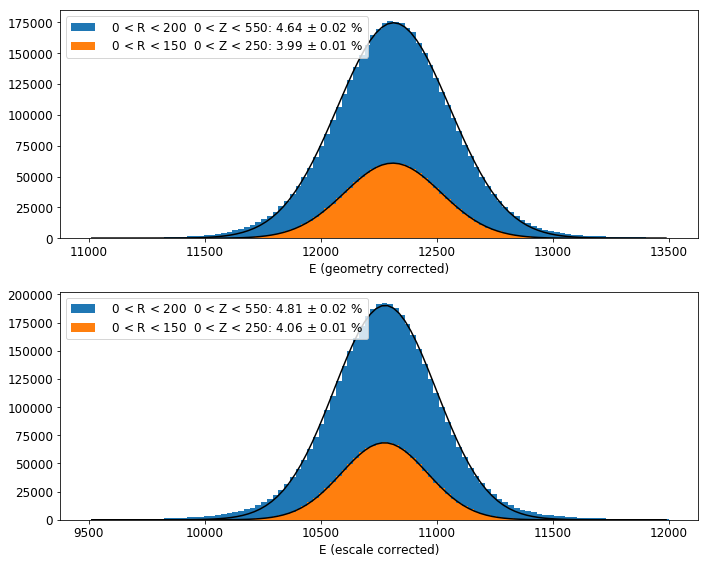

In [15]:
EGa = hst.Vaxis((11e3, 13.5e3), 100)
plt.subplot(2, 1, 1)
apt.plt_energy(EG[sel]    , EGa.bins, str_sel)
apt.plt_energy(EG[sel_fid], EGa.bins, str_sel_fid)
plt.xlabel('E (geometry corrected)')

ESa = hst.Vaxis((9.5e3, 12.0e3), 100)
plt.subplot(2, 1, 2)
apt.plt_energy(ES[sel]    , ESa.bins, str_sel)
apt.plt_energy(ES[sel_fid], ESa.bins, str_sel_fid)
plt.xlabel('E (escale corrected)')

plt.tight_layout()

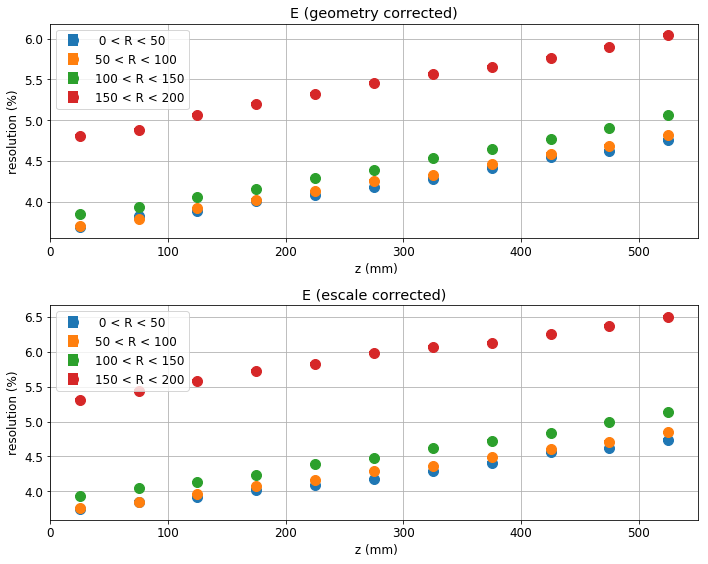

In [16]:
Ra = hst.Vaxis((0., 201.), step=50.)
Za = hst.Vaxis((0., 551.), step=50.)

plt.subplot(2, 1, 1)
apt.plt_eresolution_zr(EG, R, Z, EGa.nbins, EGa.range, Ra.bins, Za.bins)
plt.title('E (geometry corrected)')
plt.subplot(2, 1, 2)
apt.plt_eresolution_zr(ES, R, Z, ESa.nbins, ESa.range, Ra.bins, Za.bins)
plt.title('E (escale corrected)')
plt.tight_layout()

In [17]:
print('Done!')

Done!
